<a href="https://colab.research.google.com/github/Ashraf-Saleheen/For-Upwork/blob/main/Experiment_Success_With_BB_Sentiment_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtrader yfinance pyfolio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00


Starting Portfolio Value: 100000.00

=== Performance Summary ===
Initial Value: 100000.00
Final Value: 133498.11
Total Return: 33.50%
Trades Completed: 8

Daily Returns Statistics:
Average Daily Return: 0.4918%
Best Day: 0.9991%
Worst Day: -0.0352%
Volatility: 0.4330%


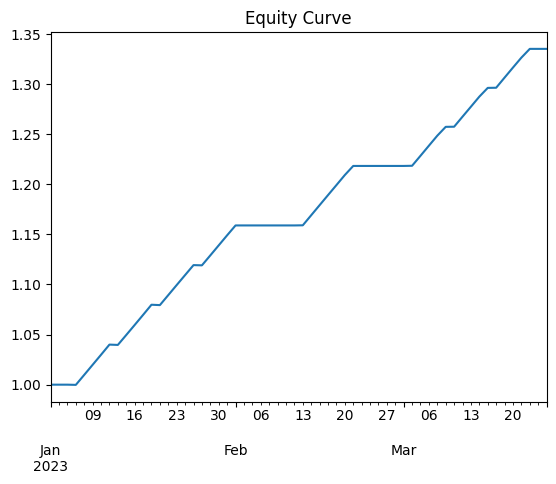

Final Portfolio Value: 133498.11


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

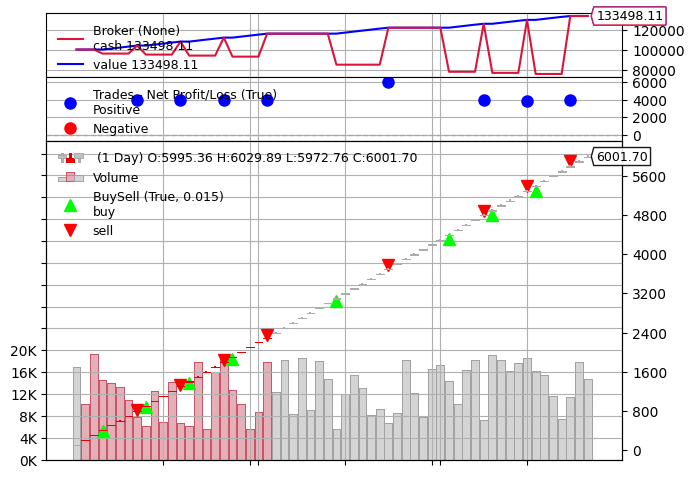

In [2]:
# Importing Necessary Libraries

import backtrader as bt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from packaging import version

# Fixing for NumPy 2.0 compatibility
if version.parse(np.__version__) >= version.parse("2.0.0"):
    np.NINF = -np.inf

# 1. Creating sample Bloomberg-style DataFrame
np.random.seed(42)
date_range = pd.bdate_range(start='2023-01-01', periods=60)  # 3 months of data
bloomberg_df = pd.DataFrame({
    'open': np.cumsum(np.random.randn(len(date_range)) * 0.5 + 100),
    'high': np.cumsum(np.random.randn(len(date_range)) * 0.5 + 100.5),
    'low': np.cumsum(np.random.randn(len(date_range)) * 0.5 + 99.5),
    'close': np.cumsum(np.random.randn(len(date_range)) * 0.5 + 100),
    'volume': np.random.randint(5000, 20000, len(date_range)),
    'sentiment_score': np.clip(np.random.randn(len(date_range)) * 0.5, -1, 1),
    'news_count': np.random.randint(5, 30, len(date_range))
}, index=date_range).round(2)

# Adding sentiment patterns
jan_dates = bloomberg_df.loc['2023-01-10':'2023-01-20'].index
feb_dates = bloomberg_df.loc['2023-02-15':'2023-02-25'].index

bloomberg_df.loc[jan_dates, 'sentiment_score'] = np.linspace(0.7, 0.9, len(jan_dates))
bloomberg_df.loc[feb_dates, 'sentiment_score'] = np.linspace(-0.9, -0.7, len(feb_dates))

# 2. Defining Data Feed
class BloombergSentimentFeed(bt.feeds.PandasData):
    lines = ('sentiment', 'news')
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('sentiment', 'sentiment_score'),
        ('news', 'news_count')
    )

# 3. Enhancing Strategy with Proper Order Management
class SentimentStrategy(bt.Strategy):
    params = (
        ('sentiment_threshold', 0.3),
        ('trade_size', 10),
        ('hold_period', 5)
    )

    def __init__(self):
        self.sentiment = self.data.sentiment
        self.active_order = None
        self.entry_dates = []
        self.exit_dates = []
        self.portfolio_values = []
        self.dates = []
        self.trade_count = 0

    def next(self):
        # Recording portfolio value and date
        self.portfolio_values.append(self.broker.getvalue())
        self.dates.append(self.data.datetime.date())

        # Closing position if hold period has elapsed
        if self.position and len(self.entry_dates) > 0:
            days_in_trade = (self.data.datetime.date() - self.entry_dates[-1]).days
            if days_in_trade >= self.p.hold_period:
                self.close()
                self.exit_dates.append(self.data.datetime.date())
                self.active_order = None

        # Entering new position if conditions met and no active order
        if not self.position and not self.active_order:
            if self.sentiment[0] > self.p.sentiment_threshold:
                self.active_order = self.buy(size=self.p.trade_size)
                self.trade_count += 1

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                self.entry_dates.append(self.data.datetime.date())
            elif order.issell():
                self.exit_dates.append(self.data.datetime.date())
            self.active_order = None

    def stop(self):
        # Calculating returns
        self.daily_values = pd.Series(self.portfolio_values, index=pd.to_datetime(self.dates))
        self.daily_returns = self.daily_values.pct_change().dropna()

        # Performance summary
        print("\n=== Performance Summary ===")
        print(f"Initial Value: {self.portfolio_values[0]:.2f}")
        print(f"Final Value: {self.portfolio_values[-1]:.2f}")
        print(f"Total Return: {(self.portfolio_values[-1]/self.portfolio_values[0]-1):.2%}")
        print(f"Trades Completed: {len(self.entry_dates)}")

        if len(self.daily_returns) > 0:
            print("\nDaily Returns Statistics:")
            print(f"Average Daily Return: {self.daily_returns.mean():.4%}")
            print(f"Best Day: {self.daily_returns.max():.4%}")
            print(f"Worst Day: {self.daily_returns.min():.4%}")
            print(f"Volatility: {self.daily_returns.std():.4%}")

            # Plotting equity curve
            import matplotlib.pyplot as plt
            (self.daily_values/self.daily_values.iloc[0]).plot(title='Equity Curve')
            plt.show()

# 4. Running Backtest
cerebro = bt.Cerebro()
cerebro.addstrategy(SentimentStrategy)
data = BloombergSentimentFeed(dataname=bloomberg_df)
cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.001)

print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
results = cerebro.run()
print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

# 5. Plotting Results
cerebro.plot(style='candlestick', volume=True)